In [34]:
import pandas as pd
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.utils import simple_preprocess
from nltk.tokenize import word_tokenize
import re
import logging
from gensim.matutils import cossim
from scipy.spatial.distance import cosine

#pour voir temps d'avancement de l'entrainement
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
#pour l'enlever
#logging.getLogger("gensim").setLevel(logging.ERROR)

In [35]:
chemin_fichier = "FOMC_statements_characteristics_050525.csv"
df=pd.read_csv(chemin_fichier)

In [36]:
#on enlève les @action car ils ne sont pas bien pris en compte par le modele
df["Statement"] = df["Statement"].apply(lambda x: re.sub(r"@\w+", "", str(x)).strip())

#on enleve les crochets puis les espaces en trop
df["Statement"] = df["Statement"].apply(lambda x: re.sub(r"\[.*?\]", "", str(x)))

df["Statement"] = df["Statement"].apply(lambda x: re.sub(r"\s+", " ", str(x)).strip())

#on se restreint qu'aux membres de la FOCM
df = df[df["Member"] == "M"].copy()

In [37]:
#on simplifie le tableau
df_speaker = df[['Date', 'Speaker', 'Statement']].copy()

#colonne contenant la longueur du statement
df_speaker['Statement_length'] = df_speaker['Statement'].str.len()

#pour chaque individu on garde seulement sa déclaration la plus longue
df_speaker = df_speaker.loc[df_speaker.groupby(['Date', 'Speaker'])['Statement_length'].idxmax()].reset_index(drop=True)

In [ ]:
#entrainement du modele pour les déclarations individuelles
documents = [TaggedDocument(words=text.split(), tags=[str(i)]) for i, text in enumerate(df_speaker["Statement"])]

model = Doc2Vec(
    vector_size=300,
    window=8,
    min_count=5,
    workers=4,
    epochs=100,
    dm=1
)

model.build_vocab(documents)
model.train(documents, total_examples=model.corpus_count, epochs=model.epochs)

In [38]:
#embeddings = [model.dv[str(i)] for i in range(len(df_speaker))]
#df_speaker["embedding"] = embeddings

#on sauvegarde dans un fichier pour pas avoir à le recalculer
#df_speaker.to_pickle("aggregated_with_embeddings_doc2vec.pkl")

#on peut sinon le récupérer directement si il a déjà été calculé
df_speaker = pd.read_pickle("aggregated_with_embeddings_doc2vec.pkl")

In [39]:
meeting_df = df.groupby("Date")["Statement"].apply(lambda x: " ".join(x)).reset_index()
meeting_df.rename(columns={"Statement": "Full_Meeting_Text"}, inplace=True)

In [40]:
#on dit que l'embedding du meeting c'est la moyenne des embeddings du meeting pondéré par leurs longueurs
def compute_weighted_meeting_embeddings(df):
    df["weight"] = df["Statement"].apply(lambda x: len(word_tokenize(x)))
    
    meeting_embeddings = {}

    for date, group in df.groupby("Date"):
        weights = torch.tensor(group["weight"].values, dtype=torch.float32)
        embeddings = torch.stack([torch.tensor(e, dtype=torch.float32) for e in group["embedding"]])
        
        weighted_emb = (weights.unsqueeze(0) @ embeddings).squeeze(0) / weights.sum()
        meeting_embeddings[date] = weighted_emb

    return meeting_embeddings

meeting_embeddings = compute_weighted_meeting_embeddings(df_speaker)

## partie 1 : mesure de l'influence

In [41]:
def cosine_sim(vec1, vec2):
    if not isinstance(vec1, torch.Tensor):
        vec1 = torch.tensor(vec1, dtype=torch.float32)
    if not isinstance(vec2, torch.Tensor):
        vec2 = torch.tensor(vec2, dtype=torch.float32)

    v1 = F.normalize(vec1, p=2, dim=0)
    v2 = F.normalize(vec2, p=2, dim=0)
    return torch.dot(v1, v2).item()

def compute_influence(row, meeting_embeddings):
    current_date = row["Date"]
    vec_i = row["embedding"]

    dates_sorted = sorted(meeting_embeddings.keys())
    idx_current = dates_sorted.index(current_date)

    if idx_current - 1 >= 0 and idx_current + 1 < len(dates_sorted):
        date_before = dates_sorted[idx_current - 1]
        date_after = dates_sorted[idx_current + 1]

        emb_before = meeting_embeddings[date_before]
        emb_after = meeting_embeddings[date_after]

        bs = cosine_sim(vec_i, emb_before)
        fs = cosine_sim(vec_i, emb_after)

        influence = fs / bs if bs != 0 else float("inf")
        return influence, fs, bs

    return float("nan"), float("nan"), float("nan")

In [42]:
df_speaker["rho_i_m"] = df_speaker.apply(
    lambda row: cosine_sim(row["embedding"], meeting_embeddings[row["Date"]])
    if row["Date"] in meeting_embeddings else float("nan"),
    axis=1
)

df_speaker[["influence", "fs", "bs"]] = df_speaker.apply(
    lambda row: pd.Series(compute_influence(row, meeting_embeddings)),
    axis=1
)

In [43]:
#calcul par speaker
speaker_influence = df_speaker.groupby("Speaker")["influence"].mean().sort_values(ascending=False)

speaker_fs = df_speaker.groupby("Speaker")["fs"].mean().sort_values(ascending=False)
speaker_bs = df_speaker.groupby("Speaker")["bs"].mean().sort_values(ascending=False)

In [44]:
#on va regarder les premiers des différentes mesures
top_inf = speaker_influence.head(15).reset_index()
top_fs = speaker_fs.head(15).reset_index()
top_bs = speaker_bs.head(15).reset_index()

top_inf.columns = ["Speaker_influence", "Influence"]
top_fs.columns = ["Speaker_fs", "FS"]
top_bs.columns = ["Speaker_bs", "BS"]

top_combined = pd.concat([top_inf, top_fs, top_bs], axis=1)

top_combined

,Speaker_influence,Influence,Speaker_fs,FS,Speaker_bs,BS
0,MR. MORIARTY,1.237313,MR. CZERWINSKI,0.613038,MR. CZERWINSKI,0.597066
1,MR. SAPENARO,1.228193,MR. RANKIN,0.540213,MR. RANKIN,0.475961
2,MR. HOLLAND,1.200007,MR. MORIARTY,0.487902,MR. MACDONALD,0.470749
3,MR. RANKIN,1.132617,MR. MULLINIX,0.455513,MR. BARRON,0.460524
4,MR. STEIN,1.111344,MR. MACDONALD,0.447713,MR. VAN NICE,0.450535
5,MR. MONHOLLON,1.110632,MS. LOGAN,0.437438,MR. MACLAURY,0.442063
6,MR. MULLINIX,1.079936,MS. BRAINARD,0.436150,MS. MESTER,0.440891
7,MR. HELLER,1.052084,MS. MESTER,0.435699,MS. LOGAN,0.438760
8,MS. RASKIN,1.050692,MR. BARRON,0.435366,MS. GOODING,0.437043
9,MR. CONRAD,1.046651,MR. RIVES,0.434465,MR. WALLACE,0.431980


## partie 2 : mesure de la diversité

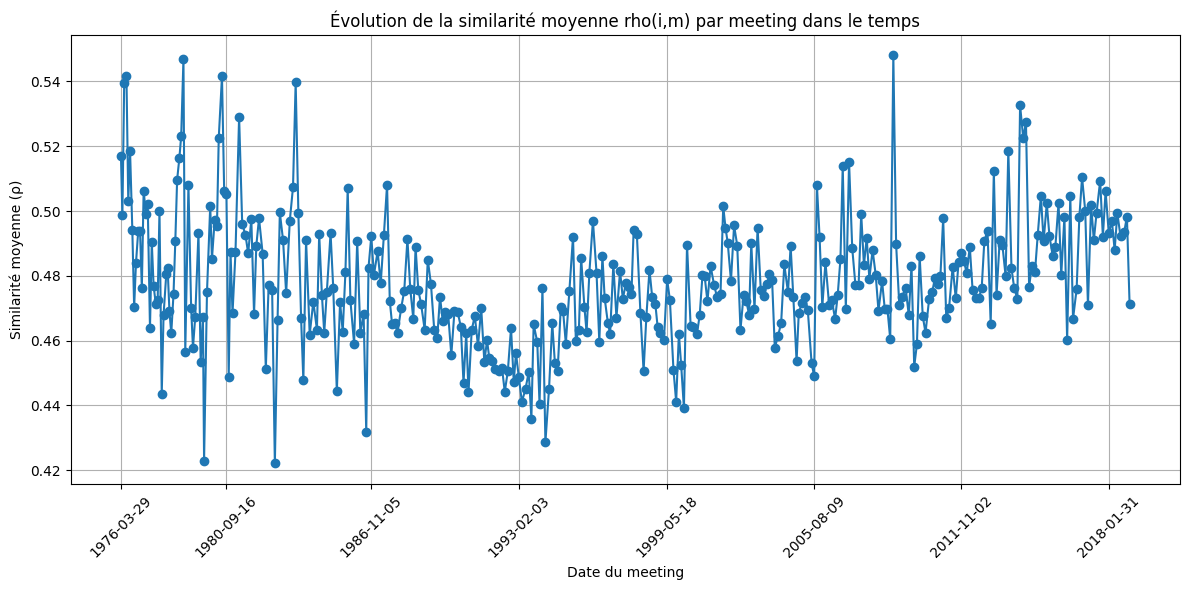

In [45]:
meeting_rho_avg = df_speaker.groupby("Date")["rho_i_m"].mean().reset_index()
meeting_rho_avg["Date"] = pd.to_datetime(meeting_rho_avg["Date"])

plt.figure(figsize=(12, 6))
plt.plot(meeting_rho_avg["Date"], meeting_rho_avg["rho_i_m"], marker='o')
plt.title("Évolution de la similarité moyenne rho(i,m) par meeting dans le temps")
plt.xlabel("Date du meeting")
plt.ylabel("Similarité moyenne (ρ)")
plt.grid(True)

xticks = meeting_rho_avg["Date"].iloc[::50] 
plt.xticks(ticks=xticks, labels=xticks.dt.strftime('%Y-%m-%d'), rotation=45)

plt.tight_layout()
plt.show()

## partie 3 : comparaison (à partir de 1980)

In [46]:
#on regarde nos données qu'à partir de 1980 comme dans l'article
df_speaker["Date"] = pd.to_datetime(df_speaker["Date"])
df_speaker[df_speaker["Date"].dt.year == 1980].index[0]

788

In [47]:
meeting_df["Date"] = pd.to_datetime(meeting_df["Date"])
meeting_df[meeting_df["Date"].dt.year == 1980].index[0]

43

In [48]:
#pour comparer on a besoin de toutes les colonnes :
meta_cols = [
    "Chair", "Vice_chair", "Day_of_meeting", "Intraday_recess",
    "Date_Order", "Count_date", "word_count", "average_word_by_date", "Regional Bank",
    "Initial", "Departure reason", "bankpres", "PARTY", "Gender", "Phd", "Age",
    "Employment", "State Born", "University", "Education", "Post", "Member"
]
meta_info = (
    df.groupby(["Date", "Speaker"])[meta_cols]
      .first()
      .reset_index()
)

meta_info["Date"] = pd.to_datetime(meta_info["Date"])

aggregated_df = (
    df_speaker
    .merge(meta_info, on=["Date", "Speaker"], how="left")
    .sort_values(["Date", "Speaker"])
    .reset_index(drop=True)
)

In [49]:
df_compare = aggregated_df.iloc[788:].copy()
df_compare['xp'] = (
    df_compare.drop_duplicates(subset=['Date', 'Speaker'])  # Une ligne par présence
    .groupby('Speaker')
    .cumcount()
)

meetingcompare_embeddings = compute_weighted_meeting_embeddings(df_compare)

df_compare[["influence", "fs", "bs"]] = df_compare.apply(
    lambda row: pd.Series(compute_influence(row, meetingcompare_embeddings)),
    axis=1
)

speaker_summary = (
    df_compare.groupby("Speaker")
    .agg({
        "influence": "mean",
        "fs": "mean",
        "bs": "mean",
        "xp": "max"  # xp = nb d’interventions - 1
    })
    .reset_index()
)

speaker_filtered = speaker_summary[
    (speaker_summary["xp"] > 10)
]

top10_influence = speaker_filtered.sort_values("influence", ascending=False)
top10_fs = speaker_filtered.sort_values("fs", ascending=False)
top10_bs = speaker_filtered.sort_values("bs", ascending=False)


In [50]:
top10_combined = pd.DataFrame({
    "Top Influence Speaker": top10_influence["Speaker"].values,
    "Influence Score": top10_influence["influence"].values,
    "FS (Influence)": top10_influence["fs"].values,
    "BS (Influence)": top10_influence["bs"].values,

    "Top FS Speaker": top10_fs["Speaker"].values,
    "FS Score": top10_fs["fs"].values,
    "Influence (FS)": top10_fs["influence"].values,
    "BS (FS)": top10_fs["bs"].values,

    "Top BS Speaker": top10_bs["Speaker"].values,
    "BS Score": top10_bs["bs"].values,
    "Influence (BS)": top10_bs["influence"].values,
    "FS (BS)": top10_bs["fs"].values
})

top10_combined.head(30)

,Top Influence Speaker,Influence Score,FS (Influence),BS (Influence),Top FS Speaker,FS Score,Influence (FS),BS (FS),Top BS Speaker,BS Score,Influence (BS),FS (BS)
0,MR. STEIN,1.111344,0.392486,0.359105,MS. LOGAN,0.437438,1.006354,0.438760,MS. MESTER,0.440891,0.995691,0.435699
1,MR. HELLER,1.052084,0.376421,0.365235,MS. BRAINARD,0.436150,1.032070,0.427273,MS. LOGAN,0.438760,1.006354,0.437438
2,MS. RASKIN,1.050692,0.393874,0.376879,MS. MESTER,0.435699,0.995691,0.440891,MS. BRAINARD,0.427273,1.032070,0.436150
3,MR. POWELL,1.042719,0.393999,0.381624,MS. GEORGE,0.421040,0.998823,0.424429,MS. GEORGE,0.424429,0.998823,0.421040
4,MR. FORD,1.041648,0.367435,0.355395,MR. BOSTIC,0.409897,1.031861,0.398251,MR. SANTOMERO,0.417683,0.980140,0.407376
5,MR. GUFFEY,1.035068,0.376228,0.368271,MR. SANTOMERO,0.407376,0.980140,0.417683,MR. ROBERTS,0.412980,0.946033,0.390019
6,MR. WARSH,1.034238,0.366297,0.358836,MR. MOSKOW,0.403190,0.999091,0.408055,MR. MOSKOW,0.408055,0.999091,0.403190
7,MR. LINDSEY,1.033460,0.338695,0.330841,MR. LAWARE,0.401163,1.025453,0.395324,MR. PARRY,0.403347,0.999243,0.400080
8,MR. GRAMLEY,1.032532,0.386537,0.374988,MR. PARRY,0.400080,0.999243,0.403347,MR. RICE,0.402738,1.002717,0.399517
9,MR. BLACK,1.032279,0.372015,0.363349,MS. YELLEN,0.399627,1.019868,0.397154,MR. BOSTIC,0.398251,1.031861,0.409897


In [51]:
aggregated_df[aggregated_df["Gender"] == "male"][["fs", "bs"]].mean()

fs    0.377176
bs    0.377193
dtype: float64

In [52]:
aggregated_df[aggregated_df["Gender"] == "female"][["fs", "bs"]].mean()

fs    0.387056
bs    0.386570
dtype: float64

les femmes ont un BS et FS plus élevés que les hommes, vérifions si les Chairs ont le BS et FS les plus élevés

In [53]:
aggregated_df["Date"] = pd.to_datetime(aggregated_df["Date"])

#on cherche les changements de chair
aggregated_df_sorted = aggregated_df.sort_values("Date").copy()
aggregated_df_sorted["Chair_shifted"] = aggregated_df_sorted["Chair"].shift()
aggregated_df_sorted["new_term"] = aggregated_df_sorted["Chair"] != aggregated_df_sorted["Chair_shifted"]
aggregated_df_sorted["chair_term_id"] = aggregated_df_sorted["new_term"].cumsum()

results = []
for term_id, group in aggregated_df_sorted.groupby("chair_term_id"):
    current_chair = group["Chair"].iloc[0]

    speaker_avg = group.groupby("Speaker")[["fs", "bs"]].mean()

    top_fs_speaker = speaker_avg["fs"].idxmax()
    top_fs_value = speaker_avg["fs"].max()
    top_bs_speaker = speaker_avg["bs"].idxmax()
    top_bs_value = speaker_avg["bs"].max()

    results.append({
        "Mandate_ID": term_id,
        "Chair": current_chair,
        "Chair_avg_fs": speaker_avg["fs"].get(current_chair, float("nan")),
        "Chair_avg_bs": speaker_avg["bs"].get(current_chair, float("nan")),
        "Top_fs_speaker": top_fs_speaker,
        "Top_fs_value": top_fs_value,
        "Top_bs_speaker": top_bs_speaker,
        "Top_bs_value": top_bs_value,
        "Chair_is_top_fs": current_chair == top_fs_speaker,
        "Chair_is_top_bs": current_chair == top_bs_speaker,
    })

results_df = pd.DataFrame(results)
results_df


,Mandate_ID,Chair,Chair_avg_fs,Chair_avg_bs,Top_fs_speaker,Top_fs_value,Top_bs_speaker,Top_bs_value,Chair_is_top_fs,Chair_is_top_bs
0,1,MR. BURNS,0.369406,0.389490,MR. RANKIN,0.465785,MR. VAN NICE,0.450535,False,False
1,2,MR. MILLER,0.362373,0.354866,MR. CZERWINSKI,0.663386,MR. CZERWINSKI,0.599726,False,False
2,3,MR. VOLCKER,0.363445,0.357323,MR. CZERWINSKI,0.596255,MR. CZERWINSKI,0.596180,False,False
3,4,MR. GREENSPAN,0.382206,0.377270,MR. LYON,0.435729,MR. MOORE,0.435142,False,False
4,5,MR. BERNANKE,0.401046,0.400592,MS. MESTER,0.492799,MR. BARRON,0.469647,False,False
5,6,MS. YELLEN,0.434986,0.434239,MR. ROBERTS,0.481474,MR. MEYER,0.511441,False,False
6,7,MR. POWELL,0.386132,0.386335,MS. GEORGE,0.452192,MS. GEORGE,0.465129,False,False


aucun des chair n'est à la fois premier en FS et en BS lorsqu'il est en position, ça ne coïncide pas avec l'article, on trace maintenant l'évolution de BS et FS sur la fenetre 1988-2005 de l'article, pas de tendance nette

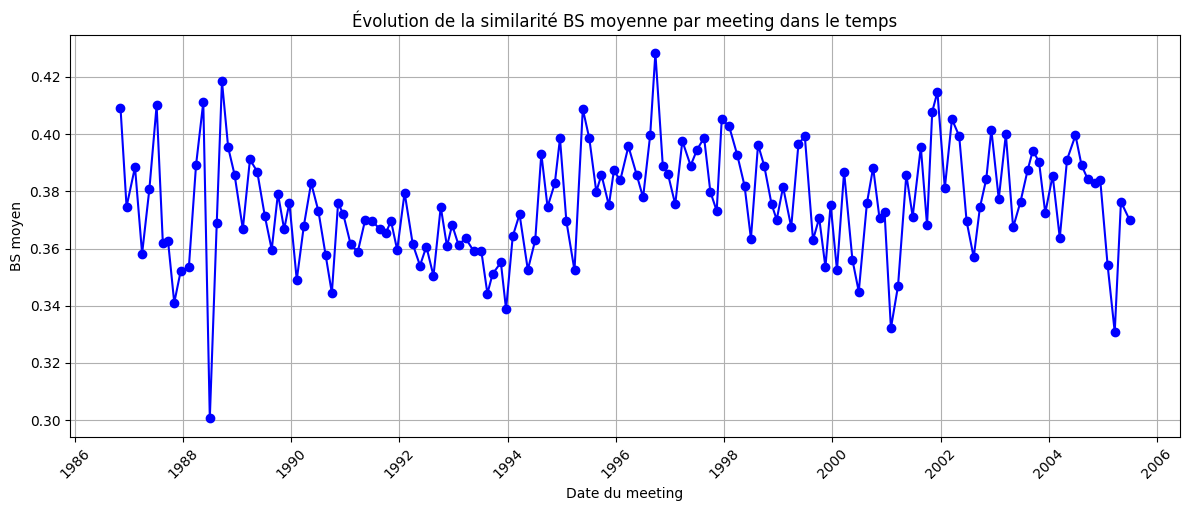

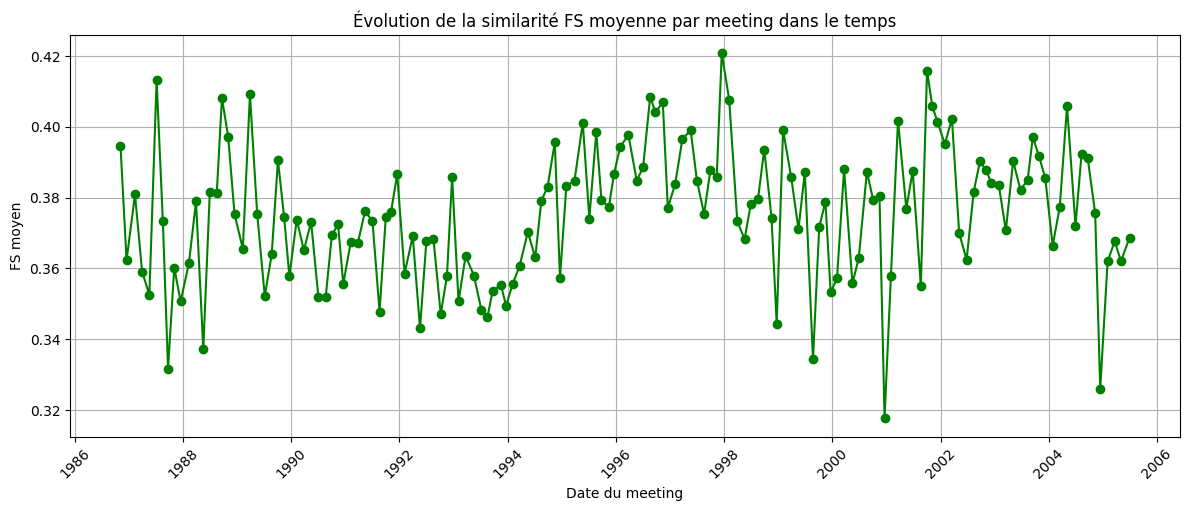

In [54]:
bs_avg_by_date = aggregated_df.groupby("Date")["bs"].mean().reset_index()
fs_avg_by_date = aggregated_df.groupby("Date")["fs"].mean().reset_index()

#on enleve le premier et dernier meeting car pas de valeurs
bs_avg_by_date = bs_avg_by_date.iloc[100:250]
fs_avg_by_date = fs_avg_by_date.iloc[100:250]

plt.figure(figsize=(12, 5))
plt.plot(bs_avg_by_date["Date"], bs_avg_by_date["bs"], marker='o', color='blue')
plt.title("Évolution de la similarité BS moyenne par meeting dans le temps")
plt.xlabel("Date du meeting")
plt.ylabel("BS moyen")
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(fs_avg_by_date["Date"], fs_avg_by_date["fs"], marker='o', color='green')
plt.title("Évolution de la similarité FS moyenne par meeting dans le temps")
plt.xlabel("Date du meeting")
plt.ylabel("FS moyen")
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()